# Alpha Oscillations in Scalp EEG
## Summary of Recordings
| Number | Length (s) | Description              |
|:------:|:----------:|:-------------------------|
| 01     | 60         | Mixed (eyes open/closed) |
| 02     | 75         | Eyes open                |
| 03     | 60         | Eyes closed              |
| 04     | 75         | Eyes open                |
| 05     | 60         | Eyes closed              |
| 06     | 90         | Mental imagery           |
| 07     | 60         | Mental imagery           |
| 08     | 75         | Eyes open                |
| 09     | 60         | Eyes closed              |
| 10     | 180        | Music (slow tempo)       |
| 11     | 180        | Music (fast tempo)       |

## Step 1: Format Recordings
In this first section, we reformat the raw recording into a fiff file, thereby making it compatible with the mne-python package. This will come in handy for preprocessing and analysis.


In [1]:
import os
import numpy as np
from mne import create_info
from mne.io import RawArray
from scipy.io import loadmat

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
eeg_files = sorted([f for f in os.listdir('raw') if f.startswith('eeg') and f.endswith('mat')])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main body.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for f in eeg_files:
    
    ## Load recording.
    mat = loadmat('raw/%s' %f)
    data = mat['data']

    ## Create info object.
    sfreq = mat['samplerate'].squeeze()
    ch_names = ['OZ']
    ch_types = 'eeg'

    info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

    ## Create Raw object.
    raw = RawArray(data, info)
    raw.info['highpass'] = 0.5
    raw.info['lowpass'] = 20.
    
    ## Save Raw object.
    raw.save('raw/%s_raw.fif' %(f.replace('.mat','')), overwrite=True, verbose=False)
    
print('Done.')

Creating RawArray with float64 data, n_channels=1, n_times=24388
    Range : 0 ... 24387 =      0.000 ...    60.968 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=30188
    Range : 0 ... 30187 =      0.000 ...    75.468 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=24108
    Range : 0 ... 24107 =      0.000 ...    60.267 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=30108
    Range : 0 ... 30107 =      0.000 ...    75.267 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=24088
    Range : 0 ... 24087 =      0.000 ...    60.218 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=36148
    Range : 0 ... 36147 =      0.000 ...    90.368 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=25108
    Range : 0 ... 25107 =      0.000 ...    62.767 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=30068
    Range : 0 ... 30067 =      0.000 ..

## Step 2: Epoching
In the next step, we perform several essential functions:
1. **Preprocessing:** We bandpass filter the data between 1 and 20 Hz to remove slow- and high-frequency noise.
2. **Epoching:** We divide the raw recording into a series of 1s trials, which will later allow for multiple power spectrum density estimates. In epoching, we also reject bad stretches of recording via amplitude rejection, tossing epochs with $\pm$ 100 $\mu V$ amplitude violations.
3. **Time-frequency representation:** We estimate the power spectrum density per epoch using the multitaper approach. We then convert the power estimates to decibels (dB) using the log normalization ($10 * log_{10}(power)$).

Note that we are only interested in certain files: eyes-open, eyes-closed, music (fast tempo).

In [2]:
import numpy as np
from mne import Epochs, make_fixed_length_events
from mne.io import Raw
from mne.time_frequency import psd_multitaper

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
eeg_files = [2, 3, 4, 5, 8, 9, 11]

## Filtering parameters.
l_freq = 1
h_freq = 20

## Epoching parameters.
tmin = -0.2
tmax = 1.0
baseline = (-0.2, 0.0)
reject = dict(eeg = 100e-6)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for f in eeg_files:
    
    ## Load data.
    raw = Raw('raw/eeg%0.2d_raw.fif' %f, preload=True, verbose=False)
    
    ## Filter data.
    raw = raw.filter(l_freq, h_freq, method='fir', phase='zero', verbose=False)
    
    ## Epoch data.
    events = make_fixed_length_events(raw, id=1)
    event_id = dict(epoch=1)
    epochs = Epochs(raw, events, event_id, tmin=tmin, tmax=tmax, baseline=baseline, 
                    reject=reject, verbose=False)
    
    ## Drop bad epochs (amplitude rejection).
    epochs.drop_bad(verbose=False)
    
    ## Estimate power spectrum density.
    psds, freqs = psd_multitaper(epochs, fmin=l_freq, fmax=h_freq, tmin=0)
    psds = 10 * np.log10(psds) # Decibel conversion.
    
    ## Save data.
    np.savez_compressed('ave/eeg%0.2d' %f, epochs=epochs.get_data(), times=epochs.times,
                        psds=psds.squeeze(), freqs=freqs)

## Step 3: Analysis
In this final section, we compare the power spectrum density estimates across all frequencies and within the alpha band (defined as 8-12 Hz).

One-way ANOVA: F = 1221.228, p = 0.000
Eyes Closed - Music: t = 34.412, p = 0.000
Eyes Cpen - Music: t = -12.307, p = 0.000


/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


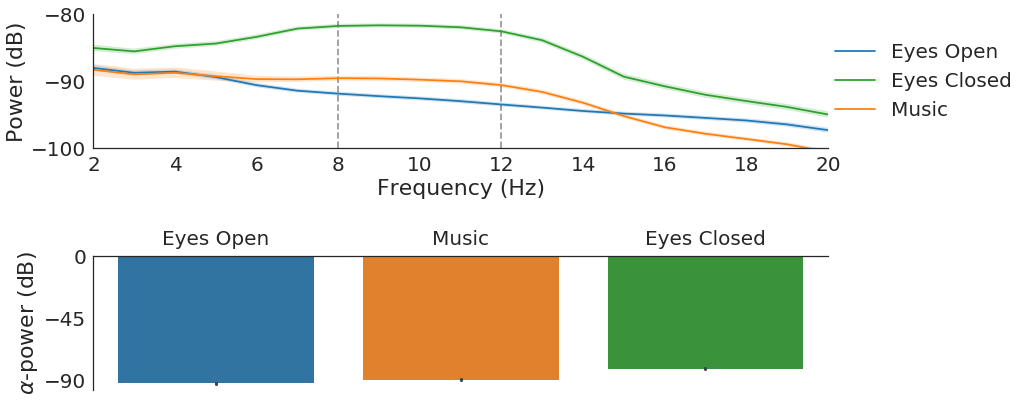

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, concat
from scipy.stats import f_oneway, ttest_ind
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
eeg_conds = {'Eyes Open':[2, 4, 8],
             'Eyes Closed':[3, 5, 9],
             'Music':[11]}

## Spectral parameters.
alpha_lim = (8, 12)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

PSDs = []
for condition, files in eeg_conds.items():
    
    for f in files:
        
        ## Load and extract data.
        npz = np.load('ave/eeg%0.2d.npz' %f)
        psds = npz['psds']
        freqs = npz['freqs'].round()
        
        ## Convert PSD to DataFrame. Append.
        psds = DataFrame(psds, columns=freqs)
        psds['Condition'] = condition
        PSDs.append(psds)
        
## Concatenate DataFrames.  
PSDs = concat(PSDs)
PSDs['Trial'] = np.arange(PSDs.shape[0])
PSDs = PSDs.melt(id_vars=('Condition','Trial'), var_name='Freq', value_name='dB')

## Make alpha-only DataFrame.
alpha = PSDs[np.logical_and(PSDs.Freq >= alpha_lim[0], PSDs.Freq <= alpha_lim[1])]
alpha = alpha.groupby(['Condition','Trial']).mean().reset_index()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Statistics and Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## One-way ANOVA.
F, p = f_oneway(*[alpha.loc[alpha.Condition==cond,'dB'] for cond in alpha.Condition.unique()])
print('One-way ANOVA: F = %0.3f, p = %0.3f' %(F,p))

## Post-hoc t-tests.
t, p = ttest_ind(alpha.loc[alpha.Condition=='Eyes Closed','dB'], 
                 alpha.loc[alpha.Condition=='Music','dB'])
print('Eyes Closed - Music: t = %0.3f, p = %0.3f' %(t,p))

t, p = ttest_ind(alpha.loc[alpha.Condition=='Eyes Open','dB'], 
                 alpha.loc[alpha.Condition=='Music','dB'])
print('Eyes Cpen - Music: t = %0.3f, p = %0.3f' %(t,p))

## Open canvas for plotting.
fig = plt.figure(figsize=(12,6))

## Plot PSDs.
ax = plt.subplot2grid((2,1),(0,0))
sns.tsplot(PSDs, time='Freq', unit='Trial', condition='Condition', value='dB', 
           color=['#1f77b4', '#2ca02c', '#ff7f0e', ], ci=95, ax=ax)

ax.vlines(alpha_lim, -100, -80, linestyle='--', alpha=0.4)
ax.set(xlabel='Frequency (Hz)', ylim=(-100,-80), yticks=[-100,-90,-80], ylabel='Power (dB)')
ax.legend(loc=7, bbox_to_anchor=(1.275,0.5))
sns.despine(ax=ax)

## Plot average 
ax = plt.subplot2grid((2,1),(1,0))
sns.barplot('Condition', 'dB', data=alpha, order=['Eyes Open', 'Music', 'Eyes Closed'], 
            palette=['#1f77b4', '#ff7f0e', '#2ca02c'], ax=ax)
ax.set(xticklabels=['Eyes Open', 'Music', 'Eyes Closed'], xlabel='', 
       yticks=[-90,-45,0], ylabel=r'$\alpha$-power (dB)')
sns.despine(ax=ax, top=False, bottom=True)

plt.subplots_adjust(left=0.05, right=0.90, bottom=0.01, hspace=0.8)